In [161]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

df = pd.read_excel('HW3_dataset.xlsx', parse_dates=True)

non_macro = df[['Equity','Bonds','Credits','Comm', 'Gold','HY']]
macro = df.drop(['Equity','Bonds','Credits','Comm', 'Date', 'Gold','HY', 'RF'], axis=1)
rf_rate = df['RF']
macro

,US_Earnings_yield,US_DIV_Yield,Equity Volatility,TED,Financial Conditions Index,Credit Subindex,Leverage Subindex,Risk Subindex,Non Financial Leverage Subindex,Credit Spread,...,IP YoY,unemployement,yields 10Y,Term Spread,Term Spread - change,DXY,CAPE,Excess CAPE Yield,Oil - change,Inflation change
0,0.0768,0.0417,0.158163,0.29,-0.10678,0.18507,-1.71996,-0.09077,-0.51194,0.01895,...,0.028756,9.5,0.116903,0.028103,-0.000569,0.028013,10.014476,0.070772,0.019758,NaN
1,0.0804,0.0430,0.111111,0.22,-0.10351,0.30240,-1.60433,-0.11935,-0.51145,0.01750,...,0.050537,9.5,0.118124,0.026924,-0.001179,0.018686,9.728057,0.067397,-0.012812,0.000975
2,0.0795,0.0419,0.101115,0.45,-0.08452,0.44201,-1.47097,-0.12841,-0.48120,0.01825,...,0.068419,9.3,0.113491,0.022291,-0.004633,-0.019031,9.984202,0.067059,-0.038936,0.003071
3,0.0808,0.0419,0.105561,0.84,0.02508,0.47537,-1.35684,-0.01192,-0.43709,0.01785,...,0.087272,8.8,0.116011,0.024811,0.002520,0.000390,10.003392,0.067335,0.000329,-0.000113
4,0.0835,0.0427,0.089781,0.58,0.10817,0.43334,-1.21202,0.08967,-0.38019,0.01775,...,0.095567,8.4,0.114453,0.030453,0.005642,0.017445,9.853582,0.066859,-0.037537,0.004110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0.0500,0.0154,0.200041,-0.30,-0.21795,0.15682,0.36311,-0.26580,-0.86215,0.01910,...,0.031050,3.7,0.031975,0.009175,-0.008294,0.026411,30.698763,0.029014,-0.091969,-0.001858
470,0.0552,0.0170,0.250597,-0.55,-0.08301,0.23531,0.32008,-0.12238,-0.78475,0.02000,...,0.045092,3.5,0.038767,0.015967,0.006792,0.031435,28.229885,0.025427,-0.112339,-0.000125
471,0.0497,0.0175,0.283736,-0.64,-0.11999,0.22885,0.28017,-0.16424,-0.72897,0.02100,...,0.030975,3.7,0.041877,0.014277,-0.001690,-0.005262,27.080767,0.022785,0.088565,-0.004524
472,0.0471,0.0167,0.285879,-0.40,-0.18624,0.17724,0.21873,-0.22137,-0.67813,0.01960,...,0.018514,3.7,0.036784,0.001984,-0.012293,-0.050006,28.455474,0.022284,-0.069109,-0.006271


In [162]:
import numpy as np
import cvxpy as cp
from dataclasses import dataclass


def compute_sharpe(w, returns, eps=1e-8):
    if w is None or returns.shape[0] == 0:
        return -np.inf
    port_ret = returns @ w
    mu = port_ret.mean()
    sigma = port_ret.std() + eps
    return float(mu / sigma)


@dataclass
class _Node:
    # Внутренний/листовой узел дерева
    feature: int = None      # индекс фичи для сплита
    threshold: float = None
    left: "._Node" = None
    right: "._Node" = None
    weights: np.ndarray = None
    is_leaf: bool = False


class AssetAllocationTree:
    def __init__(self, max_depth=3, min_leaf_size=36):
            self.max_depth = max_depth
            self.min_leaf_size = min_leaf_size
            self.root = None
            self.feature_names = None
            self.asset_names = None

    def _optimal_weights_node(self, X, returns): # Х тут остался совместимости ради
        N = returns.shape[1]
        if returns.shape[0] == 0 or N == 0:
            return None

        mu = returns.mean(axis=0)

        if np.all(mu < 0):
             return np.ones(N) / N

        sigma = np.cov(returns.T)

        if sigma.ndim == 0:
            sigma = np.array([[sigma]])
        sigma += 1e-6 * np.eye(N)


        y = cp.Variable(N)

        risk = cp.quad_form(y, sigma)
        objective = cp.Minimize(risk)

        constraints = [
            mu @ y == 1,
            y >= 0
        ]

        prob = cp.Problem(objective, constraints)

        try:
            prob.solve(solver=cp.OSQP, verbose=False)
        except Exception as e:
            print(f'Ты обезьяна: {e}')
            return None

        w_val = y.value
        w_sum = np.sum(w_val)

        if w_sum < 1e-8:
             return np.ones(N) / N

        w_opt = w_val / w_sum
        return w_opt


    def _find_best_split(self, X, returns):

        n_samples, n_features = X.shape
        best_sr = -np.inf
        best_split = None

        for j in range(n_features):

            thresholds = np.unique(
                np.percentile(X[:, j], [25, 50, 75])
            )
            for threshold in thresholds:
                left_mask = X[:, j] < threshold
                right_mask = ~left_mask

                if (left_mask.sum() < self.min_leaf_size or
                        right_mask.sum() < self.min_leaf_size):
                    continue

                w_left = self._optimal_weights_node(X[left_mask], returns[left_mask])
                w_right = self._optimal_weights_node(X[right_mask], returns[right_mask])

                sr_left = compute_sharpe(w_left, returns[left_mask])
                sr_right = compute_sharpe(w_right, returns[right_mask])

                avg_sr = (
                    left_mask.sum() * sr_left
                    + right_mask.sum() * sr_right
                ) / n_samples

                if avg_sr > best_sr:
                    best_sr = avg_sr
                    best_split = (j, threshold, w_left, w_right)

        return best_split, best_sr

    def _build_tree(self, X, returns, depth=0):

        n_samples = X.shape[0]

        if depth >= self.max_depth or n_samples < 2 * self.min_leaf_size:
            leaf_weights = self._optimal_weights_node(X, returns)
            return _Node(
                feature=None,
                threshold=None,
                left=None,
                right=None,
                weights=leaf_weights,
                is_leaf=True,
            )

        best_split, best_sr = self._find_best_split(X, returns)
        if best_split is None or not np.isfinite(best_sr):
            leaf_weights = self._optimal_weights_node(X, returns)
            return _Node(
                feature=None,
                threshold=None,
                left=None,
                right=None,
                weights=leaf_weights,
                is_leaf=True,
            )

        feature, threshold, w_left, w_right = best_split
        left_mask = X[:, feature] < threshold
        right_mask = ~left_mask

        left_node = self._build_tree(X[left_mask], returns[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], returns[right_mask], depth + 1)

        return _Node(
            feature=feature,
            threshold=threshold,
            left=left_node,
            right=right_node,
            is_leaf=False,
        )

    def fit(self, macro_features, returns, feature_names=None, asset_names=None):
        macro_features = np.asarray(macro_features)
        returns = np.asarray(returns)

        self.root = self._build_tree(macro_features, returns, depth=0)
        if feature_names is None:
            self.feature_names = [f"x{j}" for j in range(macro_features.shape[1])]
        else:
            self.feature_names = list(feature_names)

        if asset_names is None:
            self.asset_names = [f"a{k}" for k in range(returns.shape[1])]
        else:
            self.asset_names = list(asset_names)

        return self

    def _traverse(self, x, node):
        if node.is_leaf:
            return node.weights
        if x[node.feature] < node.threshold:
            return self._traverse(x, node.left)
        else:
            return self._traverse(x, node.right)

    def predict(self, macro_features):
        if self.root is None:
            raise ValueError("Сначала нужно вызвать fit().")

        macro_features = np.asarray(macro_features)
        T = macro_features.shape[0]
        example_w = self._traverse(macro_features[0], self.root)
        N = len(example_w) if example_w is not None else 0

        W = np.zeros((T, N))
        for t in range(T):
            w_t = self._traverse(macro_features[t], self.root)
            if w_t is None:
                W[t] = np.ones(N) / N
            else:
                W[t] = w_t
        return W


In [163]:
model = AssetAllocationTree()
model.fit(macro_features=macro, returns=non_macro)
preds = pd.DataFrame(model.predict(macro))
preds = pd.concat([df['Date'], preds], axis=1)

In [164]:
d = preds.groupby([0, 1, 2, 3, 4, 5]).sample()
dates_sorted = sorted(d['Date'])
dates = [(dates_sorted[i], dates_sorted[i + 1]) for i in range(len(d['Date']) - 1)]
d

,Date,0,1,2,3,4,5
301,2008-09-30,4.659772e-20,8.997462e-01,1.524763e-22,1.219464e-19,1.002538e-01,2.626052e-20
192,1999-08-31,5.632219e-19,-7.264572e-19,8.885606e-01,1.114394e-01,-2.602201e-20,8.101016e-20
173,1998-01-31,9.777366e-03,-5.816298e-18,7.184142e-01,1.523914e-18,2.232771e-18,2.718085e-01
132,1994-08-31,1.207124e-02,-4.171410e-19,-1.363504e-18,7.220563e-02,2.835097e-03,9.128880e-01
70,1989-06-30,5.076839e-02,1.888699e-17,1.016650e-01,1.861223e-01,8.175639e-02,5.796879e-01
444,2020-08-31,9.413390e-02,-7.686983e-18,5.177923e-01,4.797413e-18,5.605399e-02,3.320198e-01
458,2021-10-31,1.052385e-01,-1.828955e-18,-1.683563e-18,1.533929e-01,6.468941e-02,6.766791e-01
328,2010-12-31,4.864272e-01,-9.695044e-18,-6.925088e-18,-3.591064e-18,-8.423080e-18,5.135728e-01


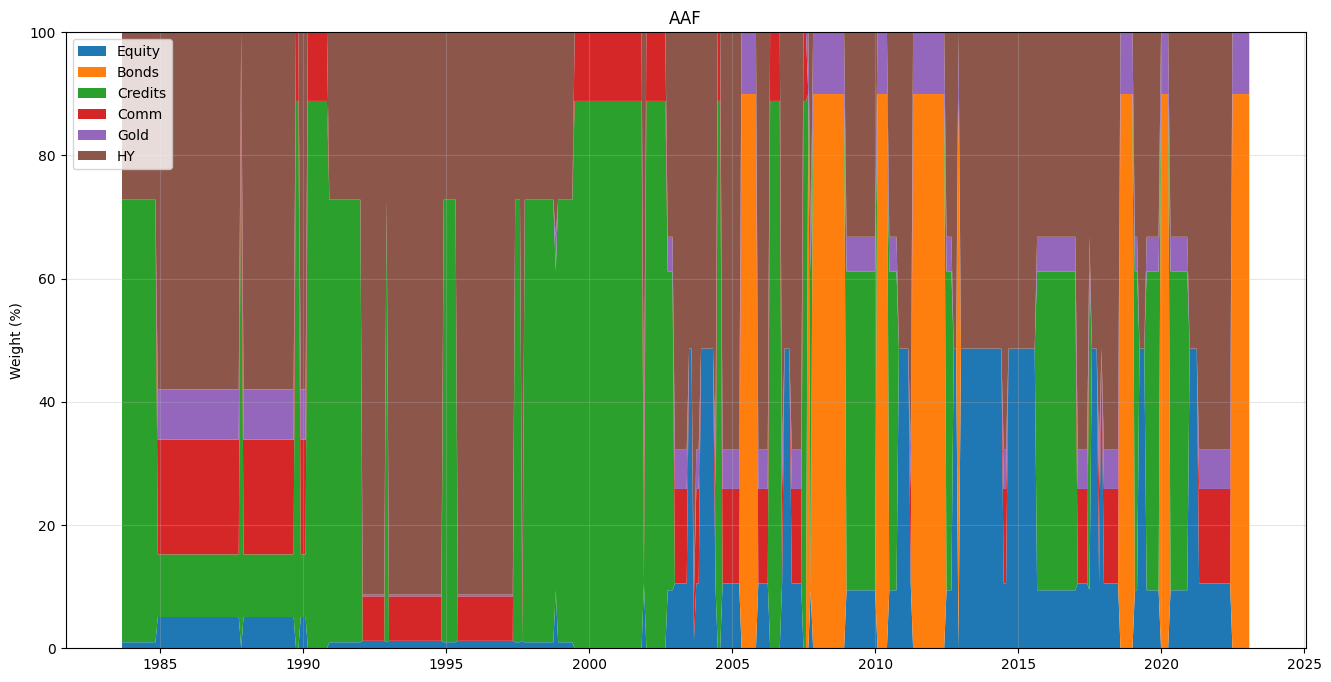

In [169]:
asset_names = ['Equity', 'Bonds', 'Credits', 'Comm', 'Gold', 'HY']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

W = pd.DataFrame(model.predict(macro))
W_pct = 100 * W
plt.figure(figsize=(16, 8))
plt.stackplot(df['Date'], W_pct.T, colors=colors, labels=asset_names)
plt.title('AAF')
plt.ylim(0, 100)
plt.ylabel('Weight (%)')
plt.grid(alpha=0.3)
plt.legend()

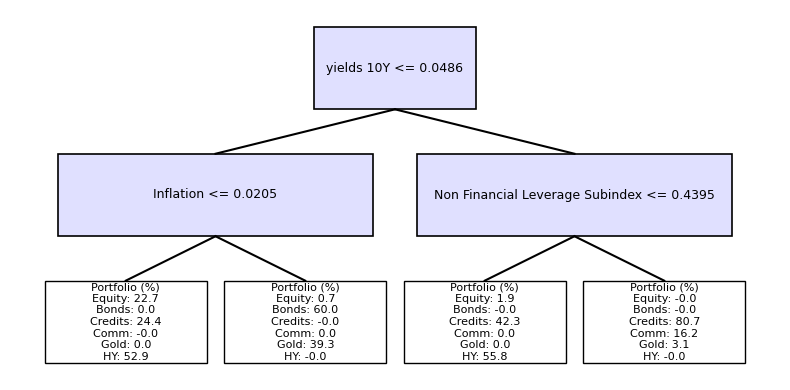

In [166]:
def plot_allocation_tree(model, figsize=(8, 4)):
    """
    Рисует структуру одного AssetAllocationTree в стиле Figure 1:
    в узлах — условие сплита, в листьях — вектор весов (в %).
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    assert model.root is not None, "Сначала нужно обучить дерево (fit)."
    feature_names = model.feature_names
    asset_names = model.asset_names

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_axis_off()
    rectangle_params = {
        0: (0.18, 0.13),
        1: (0.35, 0.13),
        2: (0.18, 0.13)
    }

    def _plot_node(node, x, y, dx, depth=0):
        box_width, box_height = rectangle_params.get(depth, (0.18, 0.13))
        if node.is_leaf:
            w = node.weights
            if w is None:
                text = "No portfolio"
            else:
                w_pct = 100 * w
                lines = ["Portfolio (%)"]
                for name, val in zip(asset_names, w_pct):
                    lines.append(f"{name}: {val:.1f}")
                text = "\n".join(lines)

            rect = Rectangle((x - box_width/2, y - box_height/2),
                             box_width, box_height,
                             linewidth=1, edgecolor='black', facecolor='white')
            ax.add_patch(rect)
            ax.text(x, y, text, ha='center', va='center', fontsize=8)
            return

        feat_name = feature_names[node.feature]
        thr = node.threshold
        label = f"{feat_name} <= {thr:.4f}"

        rect = Rectangle((x - box_width/2, y - box_height/2),
                         box_width, box_height,
                         linewidth=1.2, edgecolor='black', facecolor='#e0e0ff')
        ax.add_patch(rect)
        ax.text(x, y, label, ha='center', va='center', fontsize=9)

        y_child = y - 0.2
        x_left = x - dx
        x_right = x + dx

        ax.plot([x, x_left], [y - box_height/2, y_child + box_height/2], color='black')
        ax.plot([x, x_right], [y - box_height/2, y_child + box_height/2], color='black')

        if node.left is not None:
            _plot_node(node.left, x_left, y_child, dx/2, depth+1)
        if node.right is not None:
            _plot_node(node.right, x_right, y_child, dx/2, depth+1)

    _plot_node(model.root, x=0.5, y=0.9, dx=0.2)
    plt.tight_layout()
    plt.show()

feature_names = list(macro.columns)
asset_names = ['Equity', 'Bonds', 'Credits', 'Comm', 'Gold', 'HY']

tree = AssetAllocationTree(max_depth=2, min_leaf_size=36)
tree.fit(macro_features=macro.values,
         returns=non_macro.values,
         feature_names=feature_names,
         asset_names=asset_names)

plot_allocation_tree(tree)


In [167]:
def calculate_descriptive_stats(returns_df, periods):
    stats_list = []
    ann_factor_ret = 12
    ann_factor_std = np.sqrt(12)

    for start_date, end_date in periods:
        mask = (returns_df.index >= start_date) & (returns_df.index <= end_date)

        sub_df = returns_df.loc[mask]

        if sub_df.empty:
            print(f"Warning: No data for period {start_date} - {end_date}")
            continue

        period_label = f"{pd.to_datetime(start_date).strftime('%B %Y')} - {pd.to_datetime(end_date).strftime('%B %Y')}"

        ar = sub_df.mean() * ann_factor_ret * 100
        sd = sub_df.std() * ann_factor_std * 100
        sr = ar / (sd + 1e-8)

        period_stats = pd.DataFrame({
            'Asset': sub_df.columns,
            'AR (%)': ar.values,
            'SD (%)': sd.values,
            'SR': sr.values
        })

        period_stats['Period'] = period_label
        stats_list.append(period_stats)

    final_df = pd.concat(stats_list, ignore_index=True)
    return final_df.set_index(['Period', 'Asset'])

W.index = df['Date']
stats_table = calculate_descriptive_stats(W, dates)
print(stats_table.round(4))

                                        AR (%)    SD (%)       SR
Period                         Asset                             
June 1989 - August 1994        0       15.7234    4.5294   3.4714
                               1        0.0000    0.0000   0.0000
                               2      403.0546  134.7501   2.9911
                               3       87.2560   18.2977   4.7687
                               4       11.0176    8.2356   1.3378
                               5      682.9483  128.6625   5.3081
August 1994 - January 1998     0       13.5679    0.3791  35.7872
                               1       -0.0000    0.0000  -0.0000
                               2      287.3657  118.7386   2.4202
                               3       57.7645   11.9341   4.8403
                               4        2.2681    0.4686   4.8403
                               5      839.0338  105.9568   7.9186
January 1998 - August 1999     0       15.0343    6.7675   2.2216
          